### Dependencies

In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Finding the temperatures from the previous year (August) using historical data 

In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

#****************************************************************
#Trip dates starting from August first to August seventh of 2018
#****************************************************************

start_date = '2018-08-01'
end_date = '2018-08-07'

#--Converting string date to datetime format-----
start_dt = (dt.datetime.strptime(start_date, "%Y-%m-%d")).date()
end_dt = (dt.datetime.strptime(end_date, "%Y-%m-%d")).date()

#***********************************************************************
#Checking the weather for the previous year around the same August time
#***********************************************************************

#-------Calculate the dates one year ago from August first to August seventh of 2018---------
one_yearago_start_date = start_dt - dt.timedelta(days=365)
one_yearago_end_date = end_dt- dt.timedelta(days=365)

#****************************************
# Historical temperatures of August 2017
#****************************************

#---Finding the historical temperate data from the last year using calc_temps function above---
one_year_ago_temps = calc_temps(one_yearago_start_date, one_yearago_end_date)
Tmin =one_year_ago_temps[0][0]
Tavg = one_year_ago_temps[0][1]
Tmax = one_year_ago_temps[0][2]
#-----------------------------------------------------------------------------------------------
print(f"Trip start date:{start_date} |  Trip end date:{end_date}")
print(f"-------------------------------------------------------------")
print(f"Temperatures from last year")
print(f"------------------------------")
print(f"Start date:{one_yearago_start_date} | End date:{one_yearago_end_date}")
print(f"Mininum temp:{Tmin}")
print(f"Average temp:{Tavg}")
print(f"Maximum temp:{Tmax}")
#------------------------------------------------------------------------------------------------

Trip start date:2018-08-01 |  Trip end date:2018-08-07
-------------------------------------------------------------
Temperatures from last year
------------------------------
Start date:2017-08-01 | End date:2017-08-07
Mininum temp:72.0
Average temp:79.25
Maximum temp:83.0


#### Plotting bar chart with the temperatures data obtained above

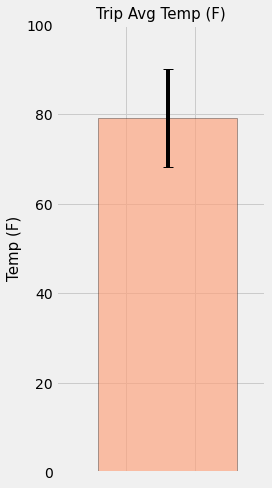

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = Tmax-Tmin
plt.figure(figsize = (4,7))
plt.bar(1.5, 
        height=Tavg, 
        yerr=error, 
        width = 2, 
        color='lightsalmon', 
        alpha = 0.65,  
        align='center',
        capsize = 5, 
        ec="black", 
        ecolor="black")
xaxis = np.arange(-0.1,3.8)
plt.title("Trip Avg Temp (F)", fontsize = 15)
plt.ylabel("Temp (F)", fontsize=15)
plt.ylim(0,100)
plt.xticks(xaxis,"")
plt.tight_layout()
plt.savefig("Images/Temperature.png")
plt.show()

### Daily Rainfall Average

#### Quering the tables to get the  daily rainfall average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,
       func.sum(Measurement.prcp),
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation]
queryresults = session.query(*sel).\
                filter(func.strftime('%Y-%m-%d',Measurement.date) >= one_yearago_start_date).\
                filter(func.strftime('%Y-%m-%d', Measurement.date) <= one_yearago_end_date).\
                filter(Measurement.station == Station.station).\
                group_by(Station.station).\
                order_by(func.sum(Measurement.prcp).desc()).all()
#----Saving the queryresults to a datframe---
Daily_rainfall_average = pd.DataFrame(queryresults, 
                                      columns = ["Station", "Total prcp", "Name", "Latitude", "Longitude", "elevation"])
Daily_rainfall_average

,Station,Total prcp,Name,Latitude,Longitude,elevation
0,USC00516128,0.36,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00514830,0.22,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,USC00519397,0.04,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


#### Calculating the Daily Temperature normals 

In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [17]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
#****************************************************************
# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-08'
#****************************************************************

#****************
# Range of Dates
#****************

#--- Use the start and end date to create a range of dates----
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date , "%Y-%m-%d")
date_array = \
    (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))
dates = [] 
for date_object in date_array:
    dates.append(date_object.strftime("%Y-%m-%d"))
print(dates)
print(f"----------------------------------------------------------------------------------------------------------------------")
#******************
df-dates dataframe
#******************

#Creating a dataframe with the range of dates 
df = pd.DataFrame(dates, columns = ["date"])
df

['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05', '2018-01-06', '2018-01-07']
-------------------------------------------------------------------------------------------------------


,date
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
5,2018-01-06
6,2018-01-07


In [18]:
#*******************************************************************
# Strip off the year and save a list of strings in the format %m-%d
#*******************************************************************
start = datetime.datetime.strptime(start_date , "%Y-%m-%d")
end = datetime.datetime.strptime(end_date , "%Y-%m-%d")
date_array = \
    (start + datetime.timedelta(days=x) for x in range(0, (end-start).days))
dates_list=[]
for date_object in date_array:
    dates_list.append(date_object.strftime("%m-%d"))
print(dates_list)
print(f"-----------------------------------------------------------------------")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals =[]
for date in dates_list:
    normals.append(daily_normals(date)[0])
print(normals)
print(f"-----------------------------------------------------------------------------------------------------------------------")
#*************************
# df1- normals dataframe 
#*************************

#Load the results of normals into a pandas dataframe.
df1 = pd.DataFrame(normals, columns = ["T-Min", "T-Avg", "T-Max"])

#*************************************************
# Daily_normals - dates and the normals dataframe 
#*************************************************

#Joining the dates and the normal dataframe on the index
Daily_normals = df.join(df1, how = "outer")
Daily_normals 

['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']
-----------------------------------------------------------------------
[(62.0, 69.15384615384616, 77.0), (60.0, 69.39622641509433, 77.0), (62.0, 68.9090909090909, 77.0), (58.0, 70.0, 76.0), (56.0, 67.96428571428571, 76.0), (61.0, 68.96491228070175, 76.0), (57.0, 68.54385964912281, 76.0)]
-----------------------------------------------------------------------------------------------------------------------


,date,T-Min,T-Avg,T-Max
0,2018-01-01,62.0,69.153846,77.0
1,2018-01-02,60.0,69.396226,77.0
2,2018-01-03,62.0,68.909091,77.0
3,2018-01-04,58.0,70.000000,76.0
4,2018-01-05,56.0,67.964286,76.0
5,2018-01-06,61.0,68.964912,76.0
6,2018-01-07,57.0,68.543860,76.0


In [19]:
#Setting date as index 
Daily_normals.set_index('date', inplace = True)
Daily_normals

,T-Min,T-Avg,T-Max
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


#### Plotting a error bar chart for the daily temperature normals

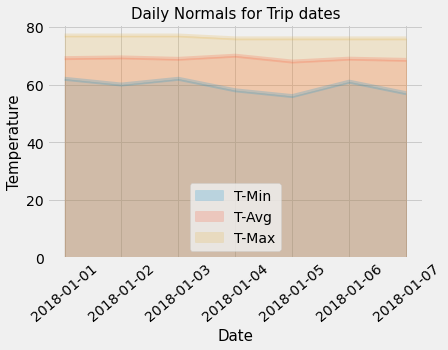

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
Daily_normals.plot(kind='area', rot =40, alpha=0.2, stacked=False, legend = 10, x_compat=True)
plt.savefig("DailyNormals.png")
plt.title("Daily Normals for Trip dates", fontsize = 15)
plt.ylabel("Temperature",fontsize = 15)
plt.xlabel("Date",fontsize = 15)
plt.savefig("Images/Daily-normals.png")
plt.legend(loc=8)
plt.show()

# Close Session


In [21]:
session.close()